In [1]:
!wget http://plasmodb.org/common/downloads/release-13.0/Pfalciparum3D7/fasta/data/PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta

--2022-10-21 20:10:26--  http://plasmodb.org/common/downloads/release-13.0/Pfalciparum3D7/fasta/data/PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta
Resolving plasmodb.org (plasmodb.org)... 128.91.204.54
Connecting to plasmodb.org (plasmodb.org)|128.91.204.54|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://plasmodb.org/common/downloads/release-13.0/Pfalciparum3D7/fasta/data/PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta [following]
--2022-10-21 20:10:27--  https://plasmodb.org/common/downloads/release-13.0/Pfalciparum3D7/fasta/data/PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta
Connecting to plasmodb.org (plasmodb.org)|128.91.204.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23723399 (23M) [application/x-fasta]
Saving to: ‘PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta.1’

PlasmoDB-13.0_Pfalc 100%[===================>]  22.62M  7.86MB/s    in 2.9s    

2022-10-21 20:10:30 (7.86 MB/s) - ‘PlasmoDB-13.0_Pfalciparum3D7_Genome.fast

We will start by inspecting the description of all of the sequences in the reference genome’s FASTA file:

In [2]:
from Bio import SeqIO

Different genome references will have different description lines, but they will generally contain
important information. In this example, you can see that we have chromosomes, mitochondria,
and apicoplast. We can also view the chromosome sizes, but we will take the value from the
sequence length instead.

In [3]:
genome_name = 'PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta'
recs = SeqIO.parse(genome_name, 'fasta')
for rec in recs:
  print(rec.description)

Pf3D7_04_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1200490 | SO=chromosome
Pf3D7_05_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1343557 | SO=chromosome
Pf3D7_02_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=947102 | SO=chromosome
Pf3D7_09_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1541735 | SO=chromosome
Pf3D7_12_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=2271494 | SO=chromosome
Pf3D7_06_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1418242 | SO=chromosome
Pf3D7_14_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=3291936 | SO=chromosome
Pf3D7_03_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1067971 | SO=chromosome
Pf3D7_07_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1445207 | SO=chromosome
Pf3D7_13_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | le

Let’s parse the description line to extract the chromosome number. We will retrieve the
chromosome size from the sequence and compute the GC content across chromosomes on a
window basis:

In [4]:
from Bio import SeqUtils
recs = SeqIO.parse(genome_name, 'fasta')
chrom_sizes = {}
chrom_GC = {}
block_size = 50000
min_GC = 100.0
max_GC = 0.0
for rec in recs:
    if rec.description.find('SO=chromosome') == -1:
        continue
    chrom = int(rec.description.split('_')[1])
    chrom_GC[chrom] = []
    size = len(rec.seq)
    chrom_sizes[chrom] = size
    num_blocks = size // block_size + 1
    for block in range(num_blocks):
        start = block_size * block
        if block == num_blocks - 1:
            end = size
        else:
            end = block_size + start + 1
        block_seq = rec.seq[start:end]
        block_GC = SeqUtils.GC(block_seq)
        if block_GC < min_GC:
            min_GC = block_GC
        if block_GC > max_GC:
            max_GC = block_GC
        chrom_GC[chrom].append(block_GC)
print(min_GC, max_GC)

16.14167716645667 43.673469387755105


Here, we have performed a windowed analysis of all chromosomes. We started by defining a window size of 50 kbp. This is
appropriate for Plasmodium falciparum (feel free to vary its size), but you will want to consider
other values for genomes with chromosomes that are orders of magnitude different from this.
</br>
Note that in the `for loop`, we ignore the mitochondrion and apicoplast by parsing the `SO` entry
to the description. The `chrom_sizes` dictionary will maintain the size of chromosomes.
</br>
The `chrom_GC` dictionary is our most interesting data structure and will contain a list of a fraction of the GC content for each 50 kbp window. So, for chromosome 1, which has a size of 640,851 bp, there will be 14 entries because this chromosome’s size is 14 blocks of 50 kbp.
</br>
Be aware of two unusual features of the Plasmodium falciparum genome: the genome is very AT-rich – that is, GC-poor. Therefore, the numbers that you will get will be very low. Also,
chromosomes are ordered based on size (as is common) but starting with the smallest size. The usual convention is to start with the largest size (such as with genomes in humans).

Now, let’s create a genome plot of the GC distribution. We will use shades of blue for the GC
content. However, for high outliers, we will use shades of red. For low outliers, we will use
shades of yellow:

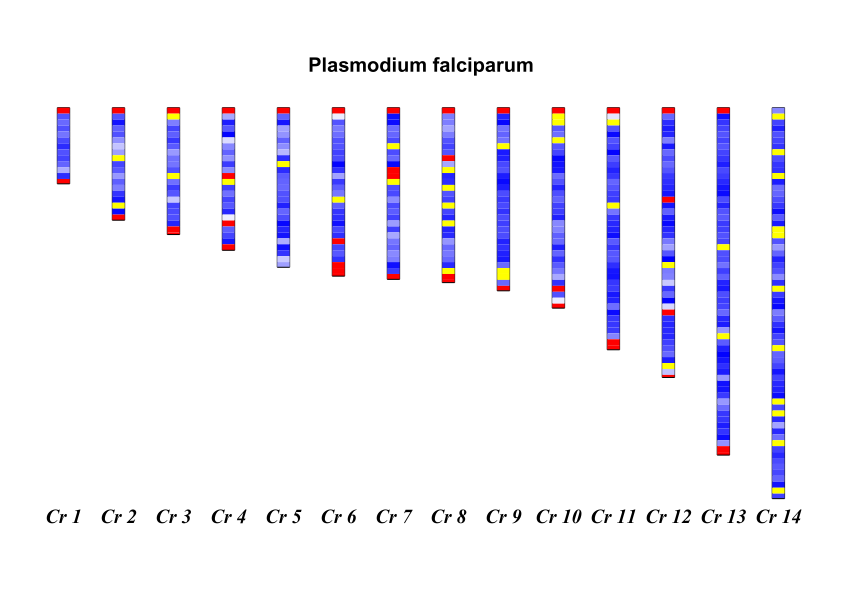

In [7]:
from IPython.core.display import Image
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import BasicChromosome

# The first line converts the return of the keys method into a list.
chroms = list(chrom_sizes.keys())
chroms.sort()

# We need the size of the biggest chromosome (14, in Plasmodium falciparum) 
# to make sure that the size of chromosomes is printed with the correct scale
biggest_chrom = max(chrom_sizes.values())

my_genome = BasicChromosome.Organism(output_format="png")

my_genome.page_size = (29.7*cm, 21*cm) # check
telomere_length = 10

bottom_GC = 17.5
top_GC = 22.0
for chrom in chroms:
    chrom_size = chrom_sizes[chrom]
    chrom_representation = BasicChromosome.Chromosome('Cr %d' % chrom)
    chrom_representation.scale_num = biggest_chrom

    tel = BasicChromosome.TelomereSegment()
    tel.scale = telomere_length
    chrom_representation.add(tel)

    num_blocks = len(chrom_GC[chrom])
    for block, gc in enumerate(chrom_GC[chrom]):
        my_GC = chrom_GC[chrom][block]
        body = BasicChromosome.ChromosomeSegment()
        if my_GC > top_GC:
            body.fill_color = colors.Color(1, 0, 0)
        elif my_GC < bottom_GC:
            body.fill_color = colors.Color(1, 1, 0)
        else:
            my_color = (my_GC - bottom_GC) / (top_GC - bottom_GC)
            body.fill_color = colors.Color(my_color, my_color, 1)
        if block < num_blocks - 1:
            body.scale = block_size
        else:
            body.scale = chrom_size % block_size
        chrom_representation.add(body)

    tel = BasicChromosome.TelomereSegment(inverted=True)
    tel.scale = telomere_length
    chrom_representation.add(tel)

    my_genome.add(chrom_representation)

my_genome.draw("falciparum.png", "Plasmodium falciparum")
Image("falciparum.png")

Note that we draw very small telomeres of 10 bp. This will produce a rectangular-like chromosome. You
can make the telomeres bigger, giving them a roundish representation, or you may have the
arguably better idea of using the correct telomere size for your species.
</br>
We declare that anything with a GC content below 17.5% or above 22.0% will be considered an
outlier. Remember that for most other species, this will be much higher.
</br>
Then, we print these chromosomes: they are bounded by telomeres and composed of 50 kbp
chromosome segments (the last segment is sized with the remainder). Each segment will be
colored in blue, with a red-green component based on the linear normalization between two
outlier values. Each chromosome segment will either be 50 kbp or potentially smaller if it’s the
last one of the chromosome